In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

# Data preprocessing

In [7]:
# Load the CSV file
path = "data/country_wise_data.csv"
df = pd.read_csv(path)  # Replace with your file path

country = 'US'
kind = 'New cases' #[Confirmed, Deaths,	Recovered, Active, New cases, New deaths, New recovered]

# Filter rows for the coutry in the "Country/Region" column
country_data = df[df["Country/Region"] == country]
country_data["Date"] = pd.to_datetime(country_data["Date"])
country_data["Date"] = (country_data["Date"] - country_data["Date"].iloc[0]).dt.days

# Find the index of the first non-zero value in the "New cases" column
first_non_zero_index = country_data[country_data[kind] != 0].index[0]
# Slice the DataFrame to start from the first non-zero row
country_data = country_data.loc[first_non_zero_index:]
MAX = max(country_data[kind])
country_data[kind] = country_data[kind]/MAX

# Extract time (e.g., "Date") and target (e.g., "New cases") columns
time_data = torch.tensor(country_data["Date"].values, dtype=torch.float32).view(-1, 1)
target_data = torch.tensor(country_data["New cases"].values, dtype=torch.float32).view(-1, 1)

C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\799233015.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data["Date"] = pd.to_datetime(country_data["Date"])
C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\799233015.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data["Date"] = (country_data["Date"] - country_data["Date"].iloc[0]).dt.days


# Plotting prediction result

In [ ]:
def plot_predictions(t_data, y_data, t_train, y_train, t_predict, predicted_values, date_ticks, country, epoch):
    """
    Plot predictions and training results.
    """
    # Ensure the save directory exists
    #if not os.path.exists(save_path):
    #    os.makedirs(save_path)

    fig, ax1 = plt.subplots(figsize=(18, 8))
    plt.title(f"{country}. Epoch: {epoch + 1}")

    # Original Data
    ax1.plot(t_data, y_data, 'go', markersize=8, label='Reported data')

    # Training Data
    ax1.plot(t_data, y_train, 'ro', markersize=8, label='Training data')

    # Predicted values
    ax1.plot(t_predict, predicted_values, color="orange", label="Predicted by PINN")

    # Format x-axis
    ax1.set_xlabel("Date")
    ax1.set_ylabel("I(t)", color="k")
    ax1.tick_params(axis='y', labelcolor="k")
    ax1.legend(loc="upper left")
    ax1.grid()

    # Set date ticks
    tick_labels = date_ticks[:len(t_data[::7])]
    ax1.set_xticks(t_data[::7].flatten())
    ax1.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor")

    # Plotting
    plt.tight_layout()
    plt.show()
    plt.close()

# Model

In [14]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t):
        return self.model(t)

# Defining the loss functions
def MSE_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

def SIR_loss(model, t, beta, gamma, mu):
    t = t.requires_grad_(True)  # Enable gradient computation for time tensor

    # Forward pass through the model
    x = model(t)

    # Compute gradients
    dx_dt = torch.autograd.grad(
        x, t, grad_outputs=torch.ones_like(x), create_graph=True
    )[0]  # First derivative

    # SIR model loss: dI/dt = beta * I - gamma * I
    sir_loss = dx_dt + beta * torch.exp(x) - gamma * torch.exp(x)

    # Return the squared loss
    return torch.mean(sir_loss ** 2)

# def SIR_loss(model, t, sigma, sigma0, mu):
#     t = t.requires_grad_(True)  # Enable gradient computation for time tensor

#     # Forward pass through the model
#     ln_I = model(t)

#     # Compute gradients (First derivative) (dlnI/dt)
#     dlnI_dt = torch.autograd.grad(
#         ln_I, t, grad_outputs=torch.ones_like(ln_I), create_graph=True
#     )[0]
#     # Compute second derivative (d^2lnI/dt^2)
#     d2lnI_dt2 = torch.autograd.grad(
#         dlnI_dt, t, grad_outputs=torch.ones_like(dlnI_dt), create_graph=True
#     )[0]

#     # Time-dependent infection rate (alpha) and its derivative (alpha')
#     alpha = sigma * t + sigma0  # Linear time-varying alpha(t)

#     I = torch.exp(ln_I)  # Recover the infected cases from the log-transformed values

#     # Compute the residual of the SIR equation
#     residual = d2lnI_dt2 + alpha * I - (sigma / alpha) * (dlnI_dt + mu)

#     # Return the mean squared error of the residual
#     return torch.mean(residual ** 2)

# Step 4: Training loop
def train_pinn_with_plot(
    model,
    optimizer,
    t_data,
    y_data,
    t_train,
    y_train,
    sigma,
    sigma0,
    mu,
    epochs,
    display_step,
    country,
    date_ticks,
):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        predictions = model(t_train)

        # Compute MSE loss
        mse_loss = MSE_loss(y_train, predictions)

        # Compute SIR loss
        pinn_loss = SIR_loss(model, t_train, sigma, sigma0, mu)

        # Total loss
        total_loss = mse_loss + pinn_loss

        # Backward pass
        total_loss.backward()
        optimizer.step()

        # Print loss
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, MSE Loss: {mse_loss.item():.4f}, SIR Loss: {pinn_loss.item():.4f}, Total Loss: {total_loss.item():.4f}")

        if epoch % display_step == 0:
            with torch.no_grad():
                predicted_values = model(t_data).detach().numpy()
            plot_predictions(
                t_data=t_data.detach().numpy(),
                y_data=y_data.detach().numpy(),
                t_train=t_train.detach().numpy(),
                y_train=y_train.detach().numpy(),
                t_predict=t_data.detach().numpy(),
                predicted_values=predicted_values,
                date_ticks=date_ticks,
                country=country,
                epoch=epoch,
            )

    # Predict values after training
    with torch.no_grad():
        predicted_values = model(t_data).detach().numpy()
        
    # Plot predictions
    plot_predictions(
        t_data=t_data.detach().numpy(),
        y_data=y_data.detach().numpy(),
        t_train=t_train.detach().numpy(),
        y_train=y_train.detach().numpy(),
        t_predict=t_data.detach().numpy(),
        predicted_values=predicted_values,
        date_ticks=date_ticks,
        country=country,
        epoch=epoch,
    )

In [ ]:
class EarlyStopping:
    def __init__(self, model, patience, display_step, sigma, sigma0, mu):
        self.patience = patience
        self.display_step = display_step
        self.model = model
        self.sigma = sigma
        self.sigma0 = sigma0
        self.mu = mu
        
        self.best_loss = np.inf
        self.wait = 0

        self.best_model = None
        self.bests_weights = None
        self.bestSigma = None
        self.bestSigma0 = None
        self.bestMu = None

    def check_early_stopping(self, current_loss, epoch):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0

            self.best_model = self.model
            self.best_weights = self.model.state_dict()
            self.bestSigma = self.sigma
            self.bestSigma0 = self.sigma0
            self.bestMu = self.mu
        else:
            self.wait += 1
        
        if self.wait >= self.patience:
            print(f"Early stopping at epoch {epoch}.")
            self.model.load_state_dict(self.best_weights)
            return True
        return False

# Training loop
def train_pinn(model, optimizer, t_data, y_data, t_train, y_train, sigma, sigma0, mu, epochs, patience, display_step, date_ticks, country):
    early_stopping = EarlyStopping(model, patience, display_step, sigma, sigma0, mu)
    losses = []

    for epoch in range(epochs):
        model.train()
        t_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
        y_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()

        y_pred = model(t_tensor)
        mse_loss = MSE_loss(y_tensor, y_pred)
        sir_loss = SIR_loss(model, t_tensor, sigma, sigma0, mu)

        total_loss = mse_loss + sir_loss

        total_loss.backward()
        optimizer.step()

        losses.append(total_loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}, MSE Loss = {mse_loss.item()}, SIR Loss = {sir_loss.item()}, Total Loss = {total_loss.item()}")
        
        if epoch % display_step == 0:
            with torch.no_grad():
                predicted_values = model(t_data).detach().numpy()
                plot_predictions(
                    t_data=t_data.detach().numpy(),
                    y_data=y_data.detach().numpy(),
                    t_train=t_train.detach().numpy(),
                    y_train=y_train.detach().numpy(),
                    t_predict=t_data.detach().numpy(),
                    predicted_values=predicted_values,
                    date_ticks=date_ticks,
                    country=country,
                    epoch=epoch,
                )

        if early_stopping.check_early_stopping(total_loss.item(), epoch):
            break
    
    return losses

# Initialize parameters
sigma = torch.tensor([0.1], requires_grad=True)
sigma0 = torch.tensor([0.1], requires_grad=True)
mu = torch.tensor([0.1], requires_grad=True)

# Training

C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)


Epoch 1, MSE Loss = 0.40919408202171326, SIR Loss = 3.375553660589503e-06, Total Loss = 0.40919744968414307


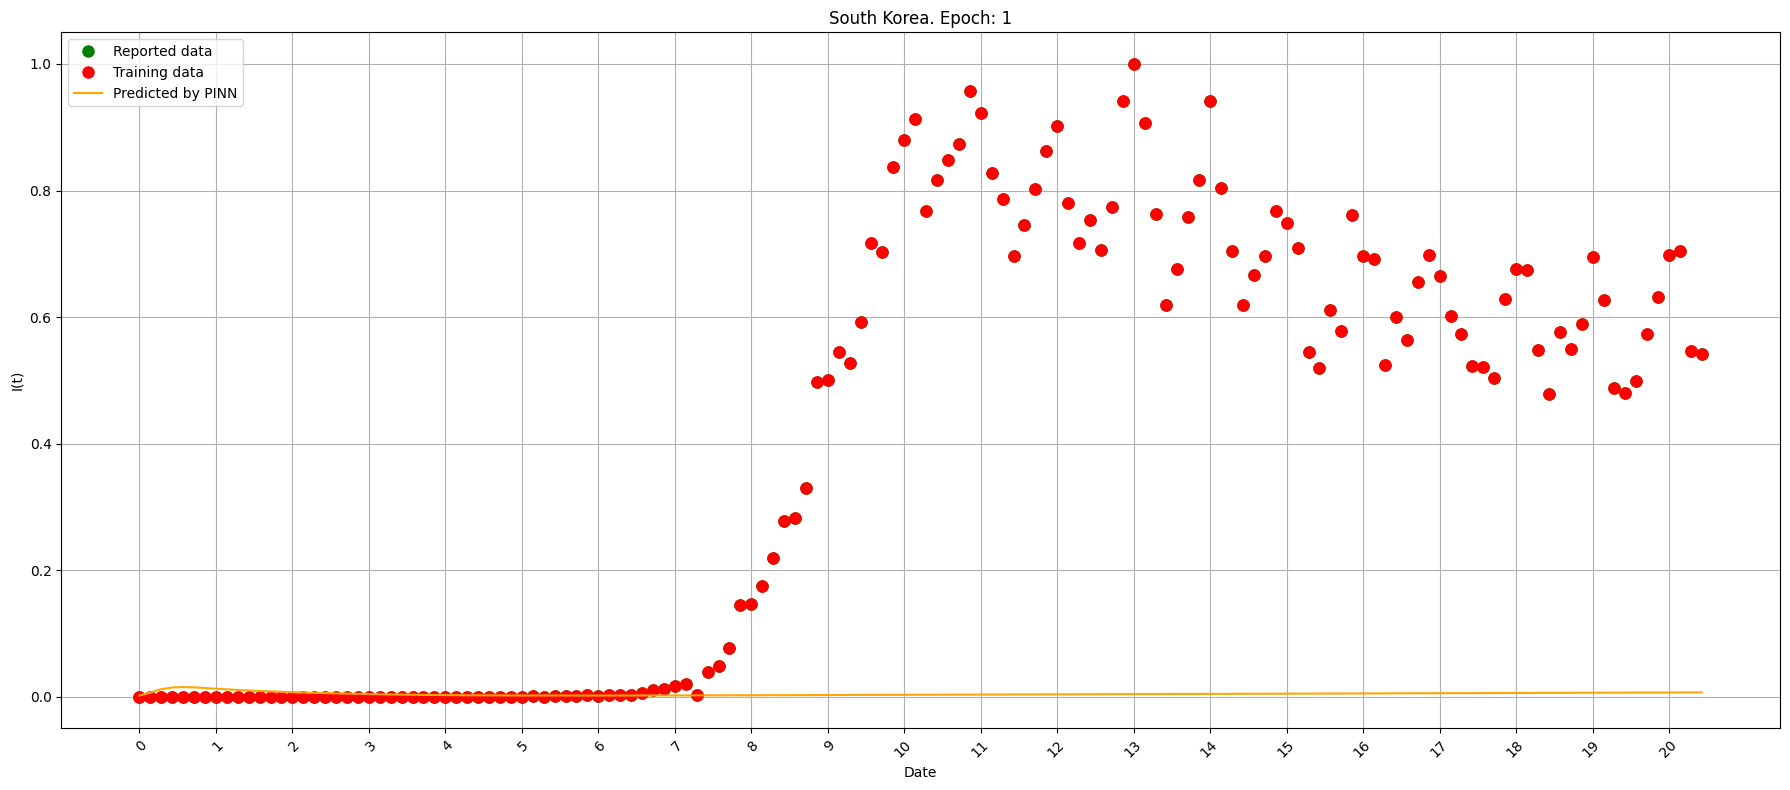

C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.028482943773269653, SIR Loss = 8.839967631502077e-05, Total Loss = 0.028571343049407005


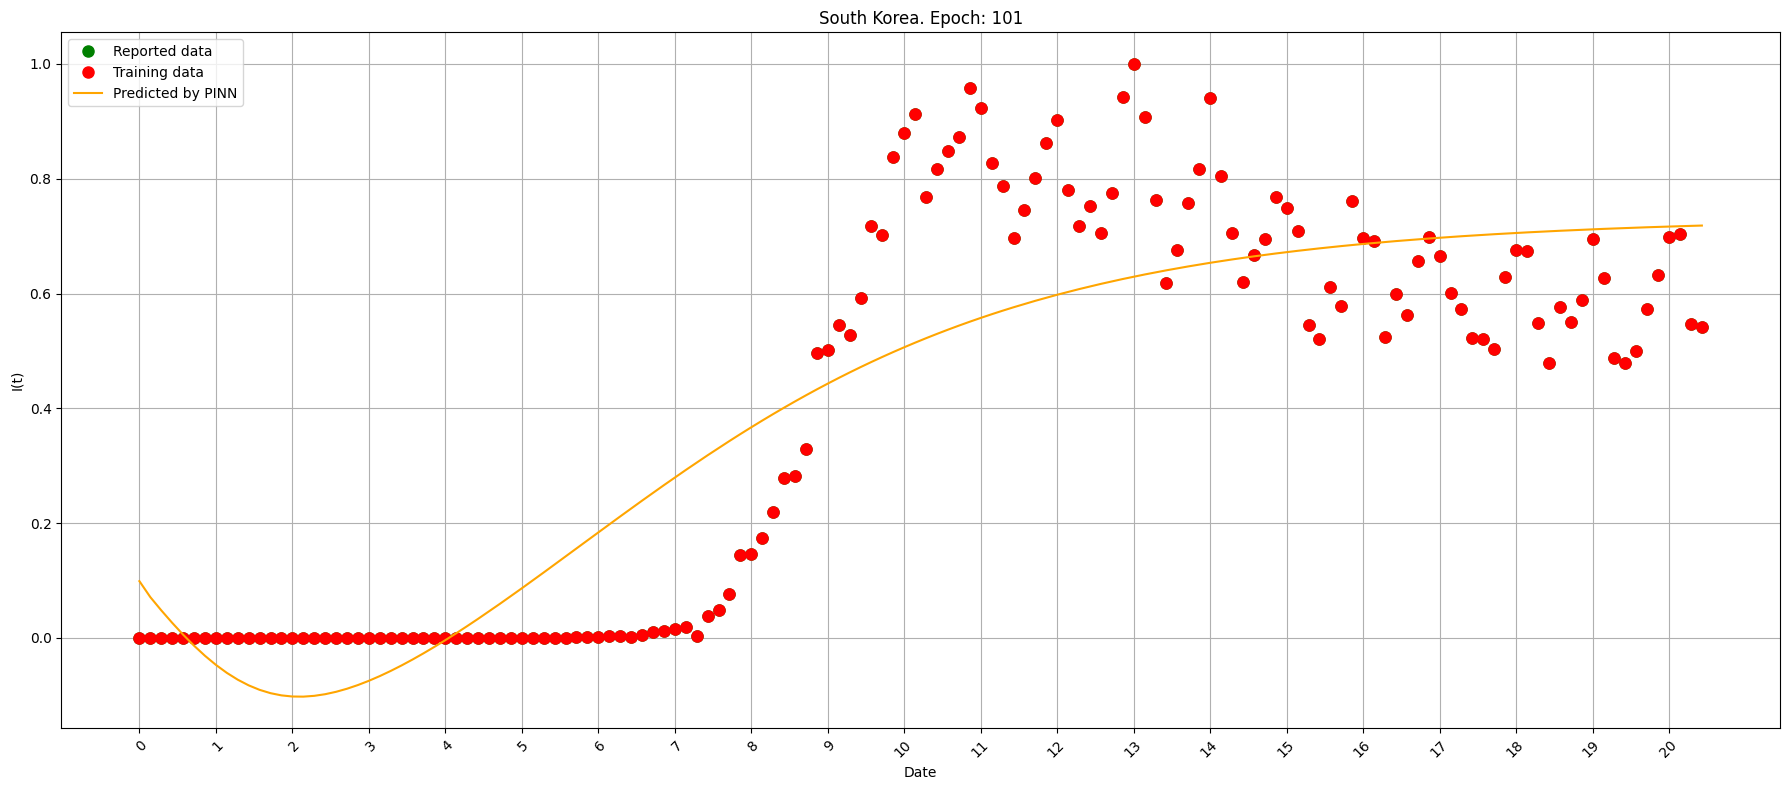

C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)


Epoch 201, MSE Loss = 0.022284679114818573, SIR Loss = 8.005986455827951e-05, Total Loss = 0.022364739328622818


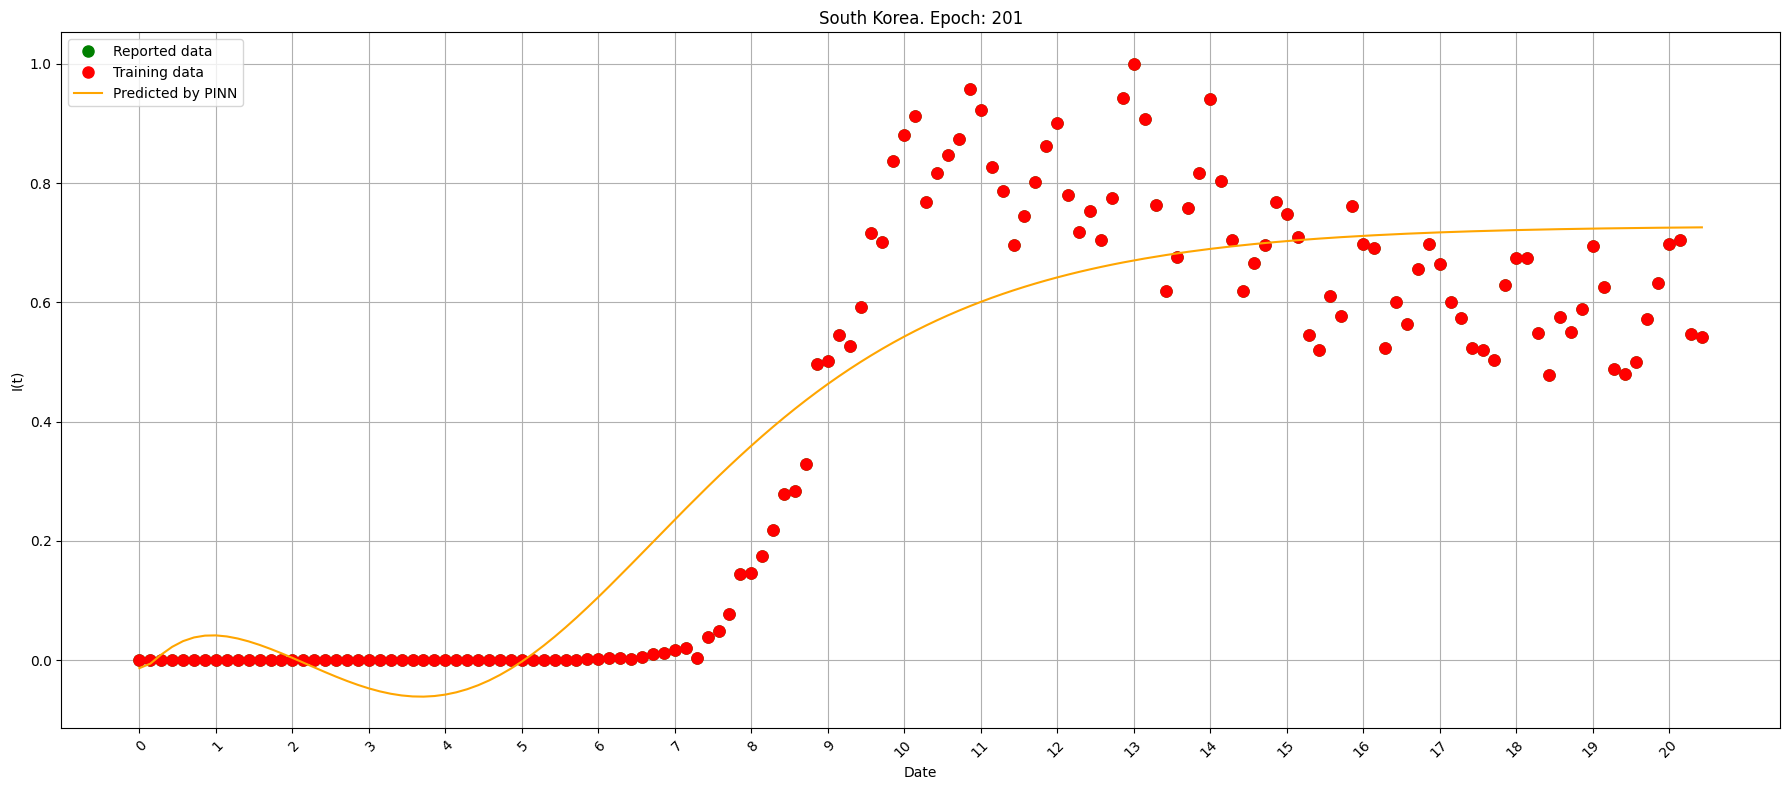

C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)


Epoch 301, MSE Loss = 0.019572347402572632, SIR Loss = 9.217477781930938e-05, Total Loss = 0.019664522260427475


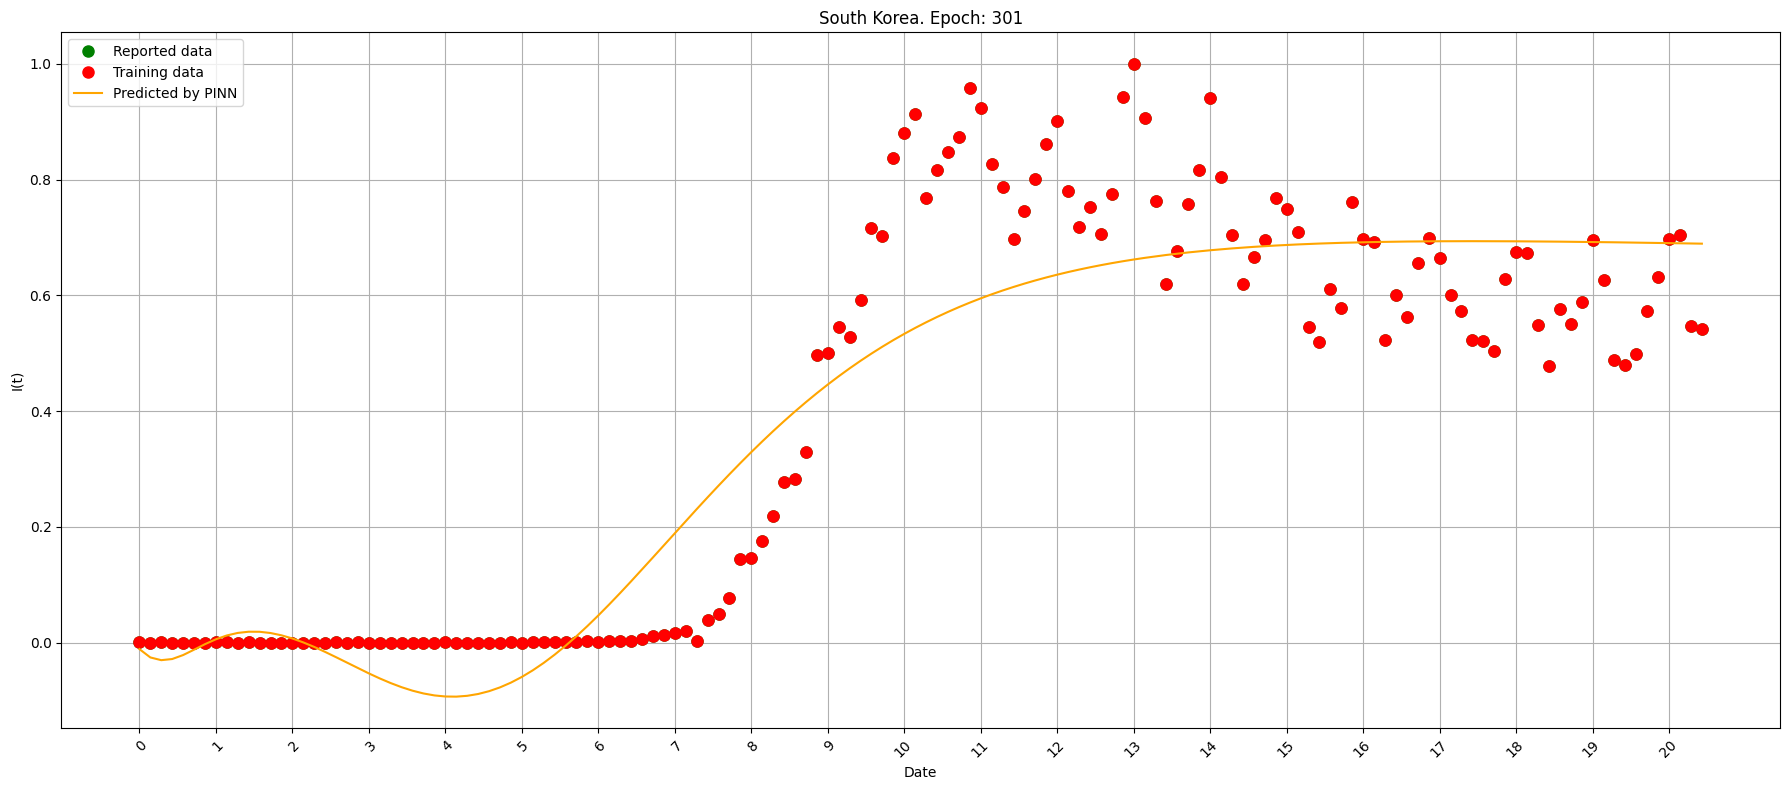

C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)


Epoch 401, MSE Loss = 0.01648247241973877, SIR Loss = 0.00010131863382412121, Total Loss = 0.016583791002631187


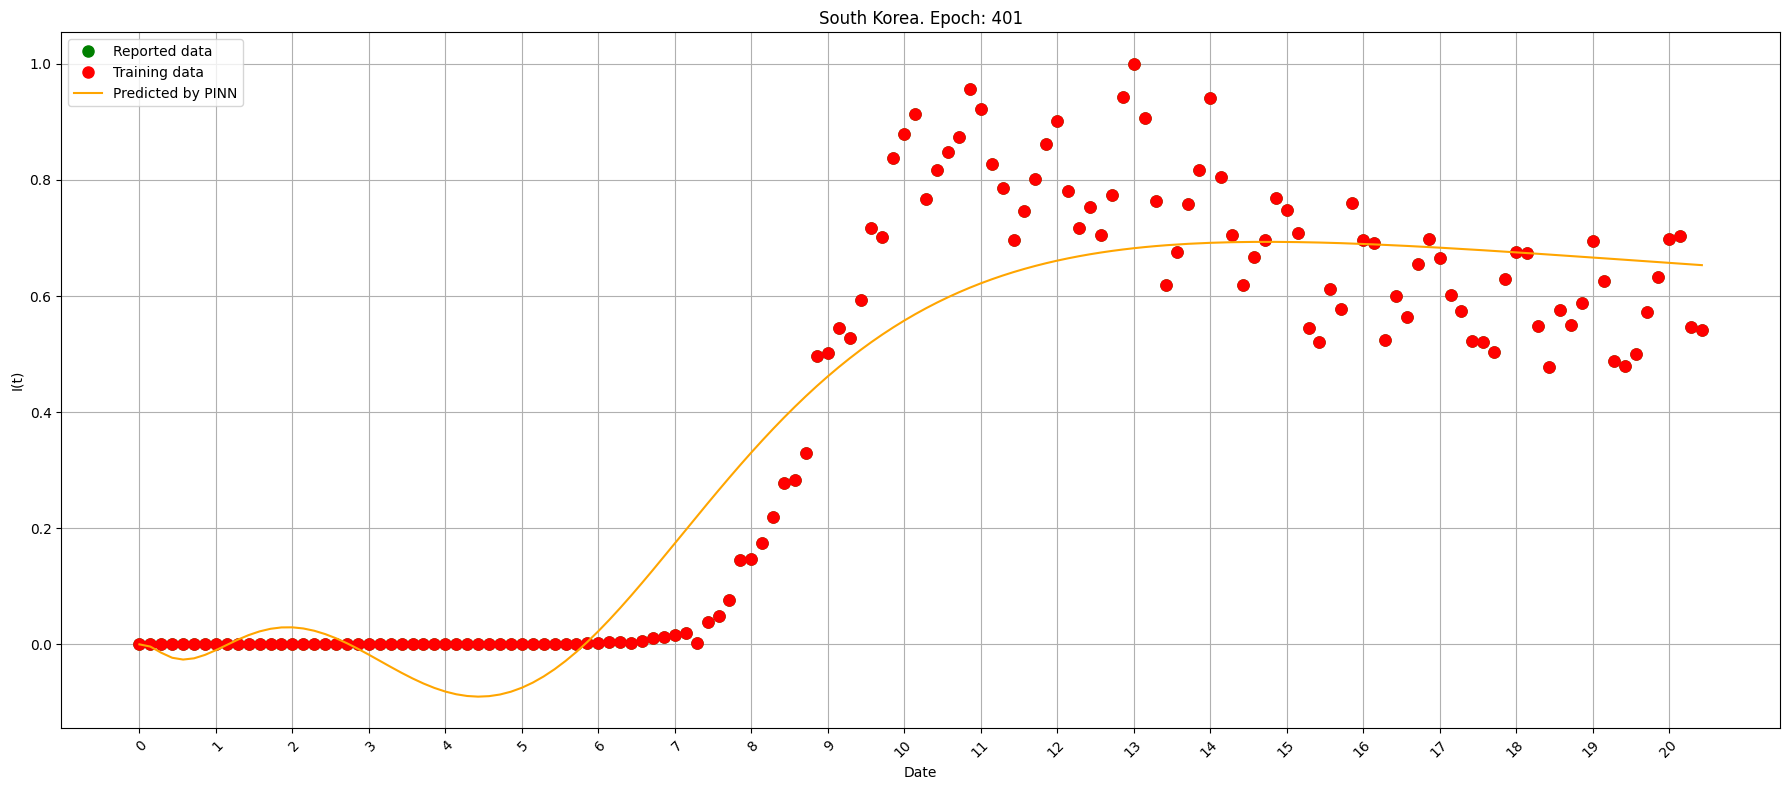

C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)


Epoch 501, MSE Loss = 0.018684275448322296, SIR Loss = 0.00010468973050592467, Total Loss = 0.018788965418934822


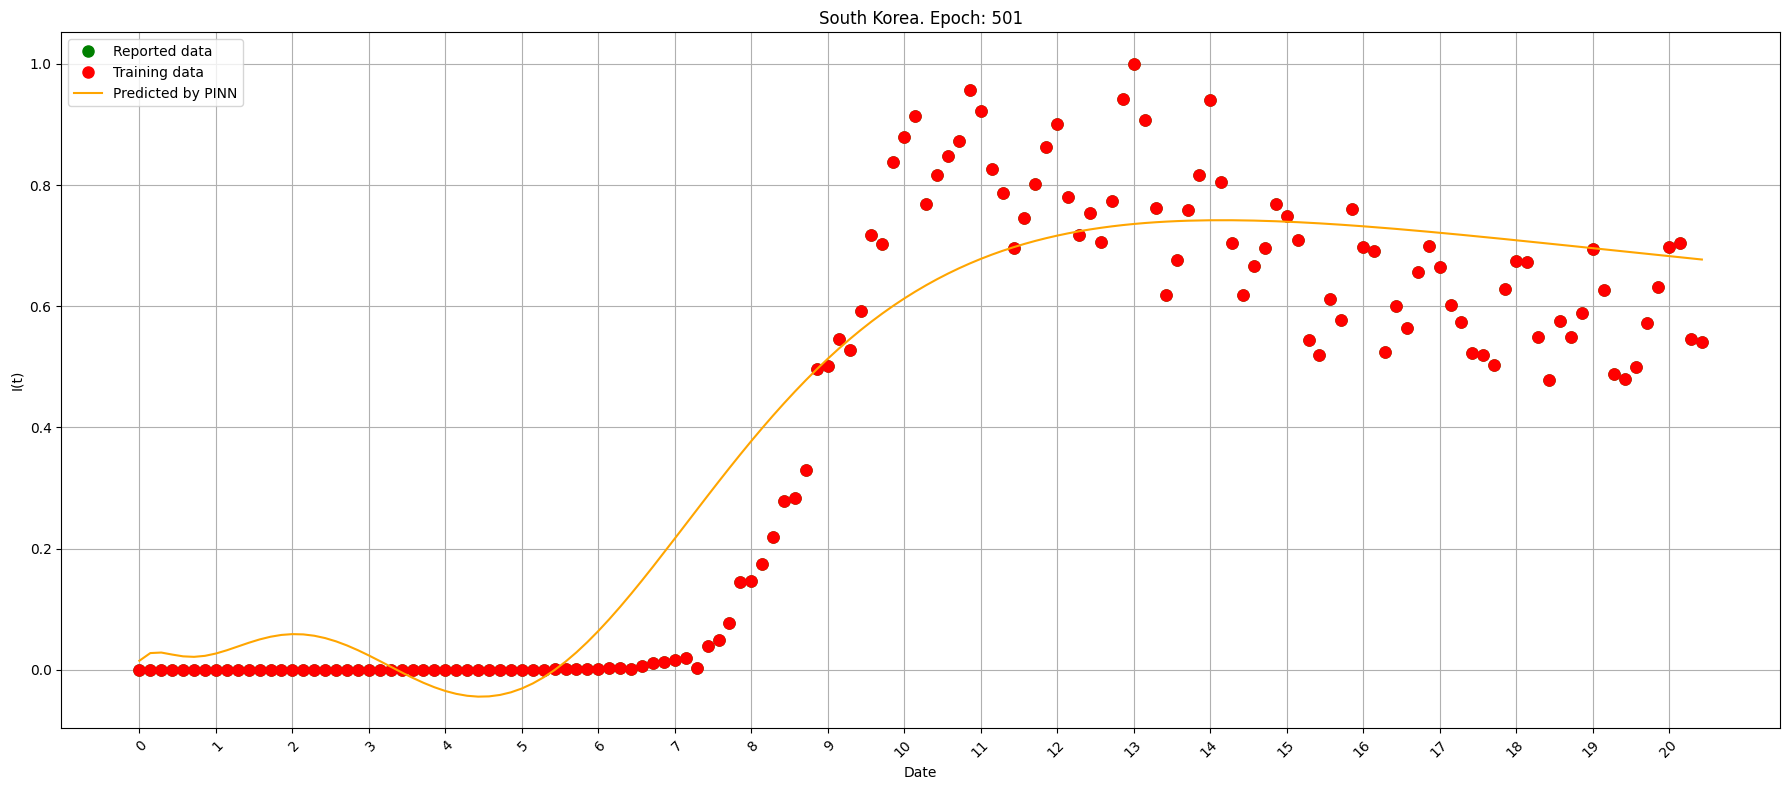

C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)


Epoch 601, MSE Loss = 0.014909550547599792, SIR Loss = 0.00010859218309633434, Total Loss = 0.015018142759799957


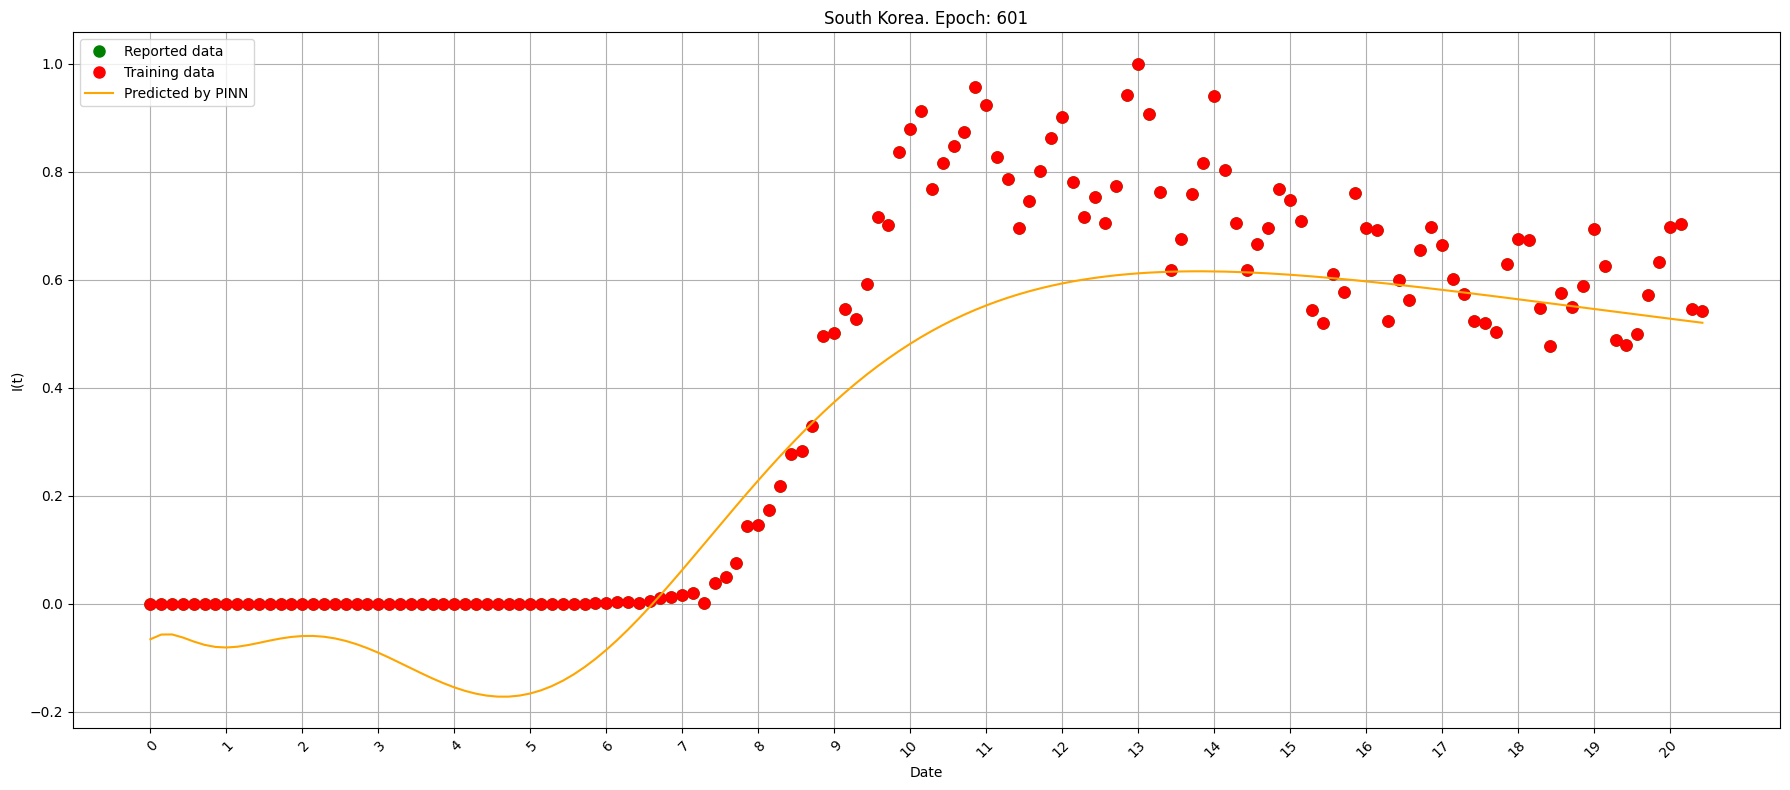

C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
C:\Users\hanky\AppData\Local\Temp\ipykernel_29624\629970378.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)


Early stopping at epoch 682.


AttributeError: 'EarlyStopping' object has no attribute 'best_model_state'

In [16]:
if __name__ == "__main__":
    # Load data
    path = "data/country_wise_data.csv"
    df = pd.read_csv(path)

    # Preprocess data
    country = "South Korea"
    kind = "New cases"

    # Initialize model, optimizer, and parameters
    model = PINN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    sigma, sigma0, mu = 0.1, 0.1, 0.1
    epochs = 10000

    train_pinn(
        model=model,
        optimizer=optimizer,
        t_data=time_data,
        y_data=target_data,
        t_train=time_data,
        y_train=target_data,
        sigma=sigma,
        sigma0=sigma0,
        mu=mu,
        epochs=epochs,
        patience=100,
        display_step=100,
        date_ticks=[str(x) for x in range(len(time_data))],
        country=country,
    )
    
    # train_pinn_with_plot(
    #     model=model,
    #     optimizer=optimizer,
    #     t_data=time_data,
    #     y_data=target_data,
    #     t_train=time_data,
    #     y_train=target_data,
    #     sigma=sigma,
    #     sigma0=sigma0,
    #     mu=mu,
    #     epochs=epochs,
    #     #patience=100,
    #     display_step=100,

    #     country=country,
    #     date_ticks=[str(x) for x in range(len(time_data))],
    # )